In [11]:
# Import libraries
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Defaults
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams.update({'font.size': 12})
plt.style.use('ggplot')

             preco_ultimo_negocio
data_pregao                      
2021-05-31                  13.20
2021-06-01                  13.18
2021-06-02                  13.32
2021-06-04                  13.14
2021-06-07                  13.15
             preco_ultimo_negocio
data_pregao                      
2024-10-01                   4.80
2024-10-02                   4.81
2024-10-03                   4.89
2024-10-04                   5.50
2024-10-04                   5.50


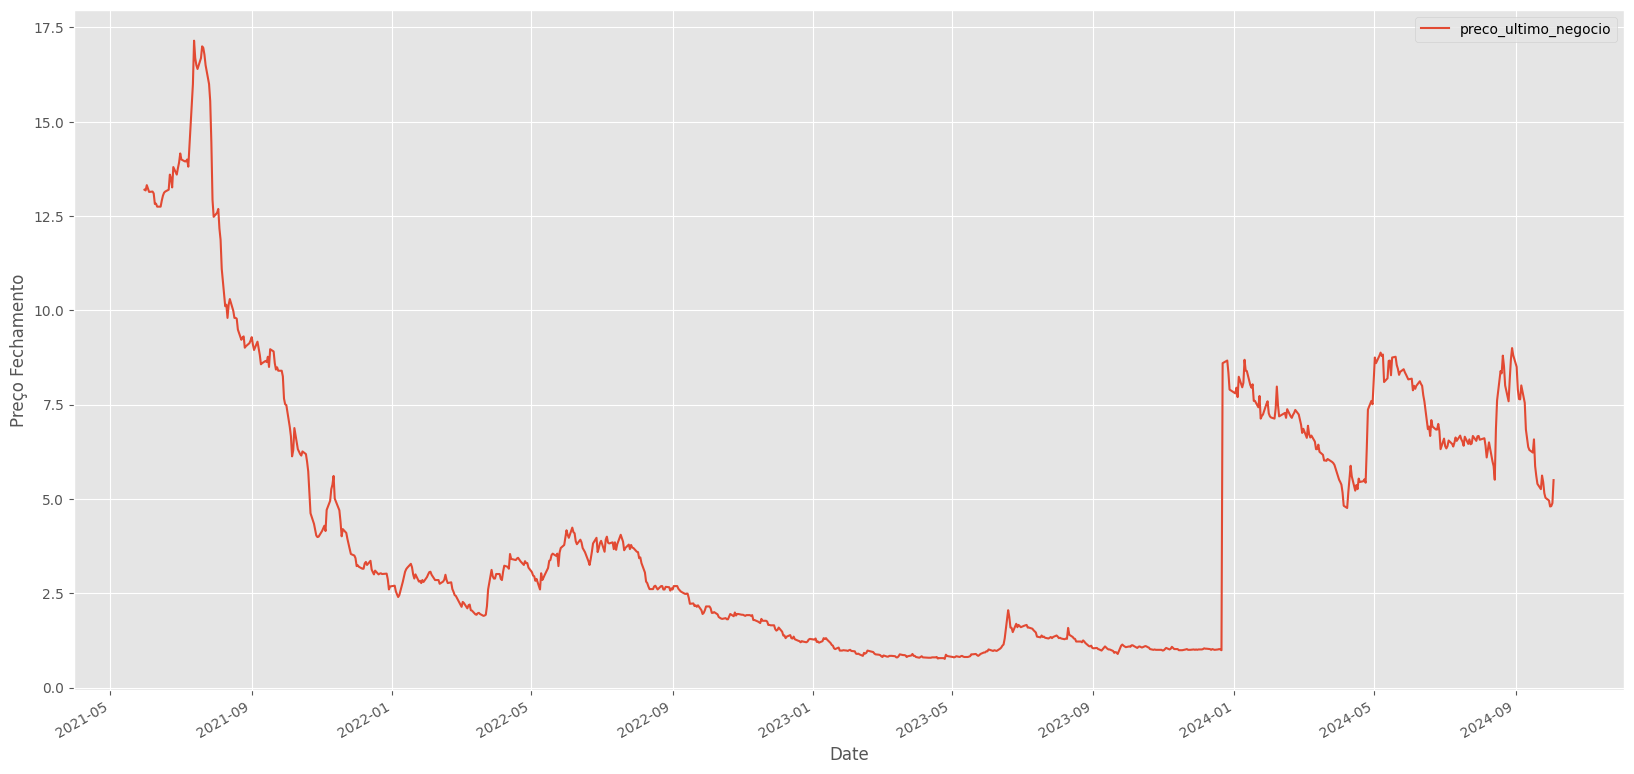

In [20]:
# Load the data
data = pd.read_csv('../dataset/dados_pregao_dotz3.csv', engine='python')
data = data[['data_pregao', 'preco_ultimo_negocio']]
# A bit of pre-processing to make it nicer
data['data_pregao']=pd.to_datetime(data['data_pregao'], format='%Y-%m-%d')
data.set_index(['data_pregao'], inplace=True)

print(data.head())
print(data.tail())
# Plot the data
data.plot()
plt.ylabel('Preço Fechamento')
plt.xlabel('Date')
plt.show()

In [17]:
# Define the d and q parameters to take any value between 0 and 1
q = d = range(0, 2)
# Define the p parameters to take any value between 0 and 3
p = range(0, 4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [21]:
train_data = data['2021-05-31':'2023-12-31']
test_data = data['2024-01-02':'2024-10-04']

In [22]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue

In [23]:
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))

The smallest AIC is 427.1128780953918 for model SARIMAX(1, 0, 0)x(3, 0, 1, 12)


In [24]:
# Let's fit this model
mod = sm.tsa.statespace.SARIMAX(train_data,
                                order=SARIMAX_model[AIC.index(min(AIC))][0],
                                seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

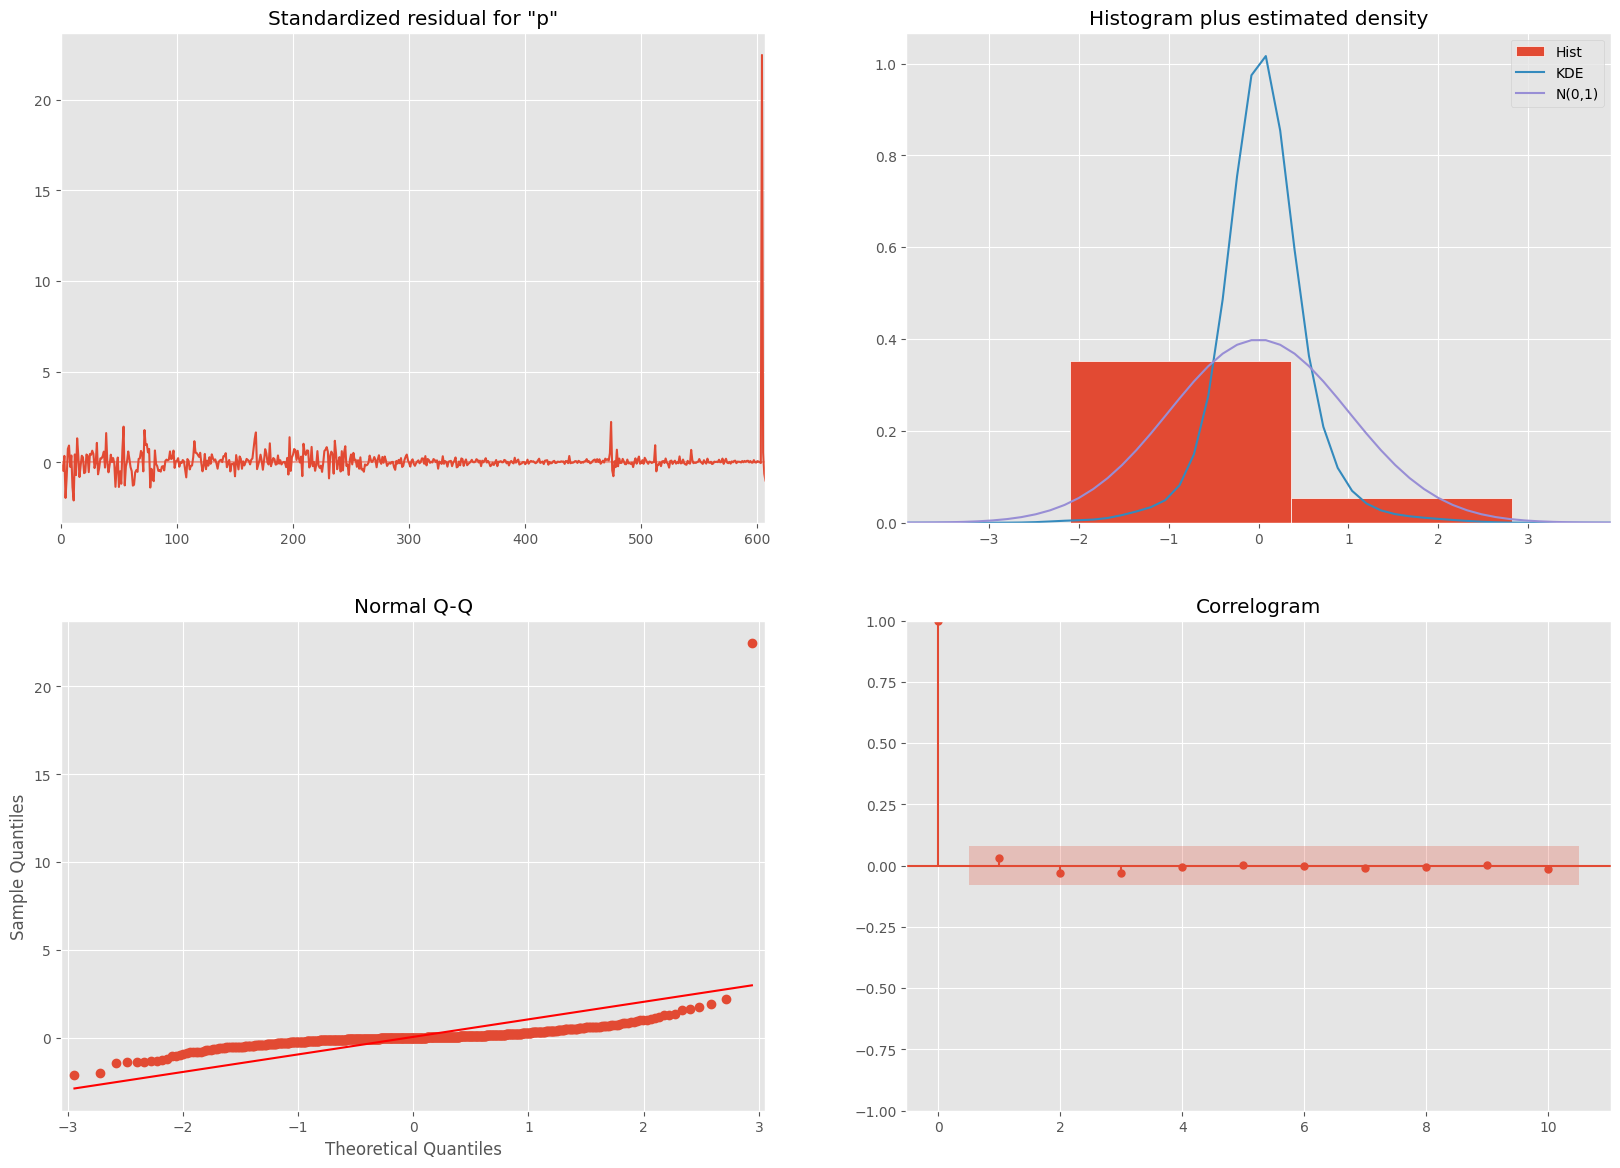

In [25]:
results.plot_diagnostics(figsize=(20, 14))
plt.show()

In [28]:
pred0 = results.get_prediction(start='2022-01-03', dynamic=False)
pred0_ci = pred0.conf_int()

In [29]:
pred1 = results.get_prediction(start='2022-01-03', dynamic=True)
pred1_ci = pred1.conf_int()

In [35]:
ax = data.plot(figsize=(20, 16))
pred0.predicted_mean.plot(ax=ax, label='1-step-ahead Forecast (get_predictions, dynamic=False)')
pred1.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_predictions, dynamic=True)')
#pred2.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_forecast)')
#ax.fill_between(pred2_ci.index, pred2_ci.iloc[:, 0], pred2_ci.iloc[:, 1], color='k', alpha=.1)
plt.ylabel('Monthly airline passengers (x1000)')
plt.xlabel('Date')
plt.legend()
plt.show()

KeyError: 'The `end` argument could not be matched to a location related to the index of the data.'